In [448]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pylab as plt

import requests
from lxml import html

from BeautifulSoup import BeautifulSoup as BS
import urllib2
import re

import pandas as pd
import numpy as np
import string


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [798]:
def years_2005_13(year,month,day,name,age):
    '''
    apply only to years 2005 to 2013 due to website format

    '''
    year_list = ['2001','2002','2003','2004','2005',
                 '2006','2007','2008','2009','2010','2011','2012']
    #year_list = ['2009']
    
    month_dict = {'JANUARY':1,'FEBRUARY':2,'MARCH':3,
               'APRIL':4,'MAY':5,'JUNE':6,
               'JULY':7,'AUGUST':8,'SEPTEMBER':9,
               'OCTOBER':10,'NOVEMBER':11,'DECEMBER':12,
             'January':1,'February':2,'March':3,
               'April':4,'May':5,'June':6,
               'July':7,'August':8,'September':9,
               'October':10,'November':11,'December':12}
    
    for i in year_list:
        #access webpage and save HTML into python
        page = requests.get("http://fiftiesweb.com/dead/dead-people-{}/".format(i)).text
        soup = BS(page)
    
        #Loop celbs and save to dates to lists
        elem_p = soup.findAll('p')[1:]
        elem = soup.findAll('b')[1:]
    
        for j in range(len(elem)):
            try:
                year_j = i
                celeb_j = elem[j].text[:-1]
                date_elem = str(elem_p[j].text[0:20])
                month_j = month_dict[string.split(date_elem,' ')[0]]
                day_j = string.split(date_elem,' ')[1]
                try:
                    day_j = string.split(day_j,'-')[0]
                except:
                    pass       
                
                try:
                    age_j = string.split(str(elem_p[j].text[-4:]),' ')[1]
                except:
                    age_j = 'nan'
                
                #print year_j, month_j, day_j, celeb_j, age_j
                year.append(year_j)
                month.append(month_j)
                day.append(day_j)
                name.append(celeb_j)
                age.append(age_j)
            except:
                pass
    return year,month,day,name,age

In [799]:
def years_2013_16(year,month,day,name,age):
    '''
    apply only to years 2013 to 2016 due to website format

    '''
    year_list = ['2013','2014','2015','2016']
    #year_list = ['2015']
    
    month_dict = {'JANUARY':1,'FEBRUARY':2,'MARCH':3,
               'APRIL':4,'MAY':5,'JUNE':6,
               'JULY':7,'AUGUST':8,'SEPTEMBER':9,
               'OCTOBER':10,'NOVEMBER':11,'DECEMBER':12,
               'January':1,'February':2,'March':3,
               'April':4,'May':5,'June':6,
               'July':7,'August':8,'September':9,
               'October':10,'November':11,'December':12,
                'October-':10,'November-':11,'December-':12,
                'Celebrity Deaths 2016JANUARY':1}
    
    for i in year_list:
        #access webpage and save HTML into python
        page = requests.get("http://fiftiesweb.com/dead/dead-people-{}/".format(i)).text
        soup = BS(page)
    
        #Loop celbs and save to dates to lists
        elem_p = soup.findAll('p')[1:]
        elem = soup.findAll('b')
        #print elem_p
        
    
        for j in range(len(elem_p)):
            year_j = i
            try:
                k = str(elem_p[j].text[0:30])
                month_b = k in month_dict.keys()
                if (month_b == True):
                    month_j = month_dict[k]
                else:
                    if (elem_p[j].text[0] == '0'):
                        day_j = elem_p[j].text[1]
                    else:
                        day_j = elem_p[j].text[0:2]

                name_elem_b = str(string.split(k,',')[0])
                celeb_j = string.split(name_elem_b,';')[1]

                try:
                    age_j = string.split(str(elem_p[j].text[-4:]),' ')[1]
                except:
                    age_j = 'nan'

                
                #print year_j, month_j, day_j, celeb_j
                year.append(year_j)
                month.append(month_j)
                day.append(day_j)
                name.append(celeb_j)
                age.append(age_j)
            except:
                pass

    return year,month,day,name,age



In [800]:
#lists
year = []
month = []
day = []
name = []
age = []

      
year,month,day,name,age = years_2005_13(year,month,day,name,age)
year,month,day,name,age = years_2013_16(year,month,day,name,age)

In [801]:
#soup

In [802]:
def func(x):
    try:
        x = int(x)
    except:
        x = 'nan'
    return x

year = map(lambda x: func(x),year)
month = map(lambda x: func(x),month)
day = map(lambda x: func(x),day)
age = map(lambda x: func(x),age)

dict = {'year':year,
        'month':month,
        'day':day,
        'name':name,
        'age':age}

df = pd.DataFrame(data=dict)
print len(df)
df  = df.drop(df.day[df.day == 'nan'].index)
#df.to_csv('data/dead_celebs_2013_16.csv')
print len(df)
df.head()

964
960


,age,day,month,name,year
0,89,15,1,Ruth Warrick,2005
1,84,17,1,Virginia Mayo,2005
2,86,22,1,Rose Mary Woods,2005
3,79,23,1,Johnny Carson,2005
4,69,25,1,Ray Peterson,2005


In [803]:
counts = []
dates = []

years = df.year.unique()
months = df.month.unique()

c = 0 

for i in years:
    dg = df.groupby('year').get_group(i)
    for j in months:
        try:
            dh = dg.groupby('month').get_group(j)
            l = len(dh)
        except:
            l = 0
        #print "{}-{}".format(i,j)
        counts.append(l)
        if (c%10 == 0):
            dates.append("{}-{}".format(i,j))
        else:
            dates.append(" ")
        c = c+1
        #counts["{}-{}".format(i,j)] = len(dh)

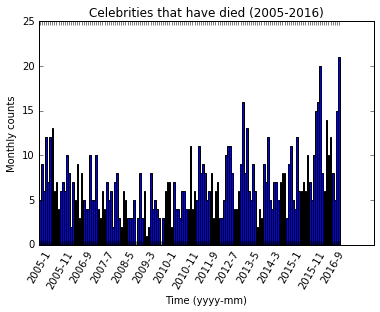

In [804]:
plt.figure()

N = len(counts)
ind = np.arange(N)
w = 0.35

y = counts
x = dates

plt.bar(ind,y)

plt.title('Celebrities that have died (2005-2016)')
plt.ylabel('Monthly counts')
plt.xlabel('Time (yyyy-mm)')
plt.xticks()
plt.xticks(ind+w,x,rotation=60)

plt.show()

80.0 15.1224188213


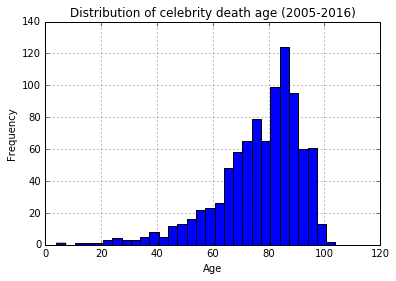

In [807]:
#plt.figure()
df_crop_age  = df.drop(df.age[df.age == 'nan'].index)
df_crop_age.age.hist(bins=30)
print df_crop_age.age.median(),df_crop_age.age.std()
plt.title('Distribution of celebrity death age (2005-2016)')
plt.ylabel('Frequency')
plt.xlabel('Age')

In [368]:


for i in elem_p:
    print i
    try:
        i = re.sub("strong", "b", i)
        print 'sub'
    except:
        pass


<p><b><u>Gone But Not Forgotten &#8211; 2012</u></b></p>
<p>January 17 &#8211; <b>Johnny Otis,</b> Singer/Songwriter &#8211; &#8220;Willie and the Jive Hand&#8221; also wrote &#8220;Every Beat of My Heart&#8221; &#8211; age 90</p>
<p>January 20 &#8211; <b>Etta James,</b> Singer &#8211; Jazz/Blues singer &#8220;Dance With Me&#8221;, &#8220;At Last&#8221; won 6 Grammy Awards &#8211; age 73</p>
<p>January 22 &#8211; <b>Joe Paterno,</b> College football coach &#8211; Penn State head coach for 46 years &#8211; age 85</p>
<p>January 24 &#8211; <b>James Farentino,</b> Actor &#8211; &#8220;The Bold Ones&#8221; (1967-72) &#8220;The Final Countdown&#8221; (1980) &#8211; age 73</p>
<p>January 26 &#8211; <b>Ian Abercrombie,</b> Actor &#8211; Mr. Pitt on &#8220;Seinfield&#8221; also Alfred Pennyworth in &#8220;Birds of Prey&#8221; &#8211; age 77</p>
<p>January 26 &#8211; <b>Robert Hegyes,</b> Actor &#8211; Epstein on &#8220;Welcome Back Kotter&#8221; (1975-79) &#8211; age 60</p>
<p>February 01 &#82

In [365]:
i

<p>Copyright 2015-2020. Michael Rich. All rights reserved. WWW.FIFTIESWEB.COM is a creation of RichWeb and is not endorsed or sponsored by or affiliated with any of the products, services, programs, celebrities or entities mentioned herein.</p>

In [ ]:
#df.to_csv('data/dead_celebs_2013_16.txt')
re.sub(r"strong", "b", soup_par)

In [364]:
soup_ex = BS('<p>Blah blah blah <a href="http://google.com">Google</a></p>')
for a in soup_ex.findAll('a'):
    print a
    print a['href']
    a['href'] = a['href'].replace("google", "mysite")
    print a['href']

<a href="http://google.com">Google</a>
http://google.com
http://mysite.com


In [342]:
for a in soup.findAll('p'):
    print a
    a=a.replace("grateful", "not grateful")
    print a
    break

<p>The Fiftiesweb is grateful to Paula Valenzuela for her very gracious help with compiling this list!</p>


TypeError: 'NoneType' object is not callable

In [315]:
print soup.body.findAll(text=re.compile('^strong$'))

[]


In [ ]:
#Wikipidia version (more difficult)
html = urllib2.urlopen("https://en.wikipedia.org/wiki/Deaths_in_2016")
soup = BS(html)
elem = soup.findAll('li')
print elem[33].text